In [8]:
# Features:
# 1. Enable a GPU with "cuda"
# 2. Saving education progress
# 3. Saving weighs and baises
# 4. Want to see how looks beetween layers results

# 0. Setup enviroment
# 0.1. Set up libraries
# 0.2. Set up folders with images
# 0.3. Set up global names


# 1. About data
#    1.1 Importing data
#    1.2 Data destribution with grafic or pie chart # tran vs test
# 2. Data normalisation and reshape
#    2.1. images into proper size reshape (might be with cv2 and contours) 
#    2.2. data separation to train and test

# 3. chosing data model and setup
#     3.1 Batch_size to choose
#     3.2 Adam parameters
#     3.3 Dropout 
#     4.1 between education accuracy result
#   conv 32, 4,4 
#   conv 64, 4,4
#   conv 128,4,4
#   conv 128,4,4
#   512 input Neurons
#   4 hidden layer
#   1 output with 0/1 - has tumor or not - softmax activation

# Train CNN
# show training results, model performance

# Avaluate model 
# confusion matrix

# model results accuracy

In [151]:
# imports
import cv2
import os, sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [140]:
# path to images + global vars

EXEPT_SIZE = 70
NUMBER_OF_EXAMPLES = 205

dir_path = os.getcwd()
labels_file_path = fr"{dir_path}\\Train.csv"
train_folders_path = fr"{dir_path}\\Train"
docs_images_path = fr"{dir_path}\\docs"

In [141]:
# open data files
csvFile = pd.read_csv(labels_file_path)
labels_file_no_null = csvFile[csvFile["Path"].notnull()]
labels_file = labels_file_no_null.reset_index(drop=True)

labels_file_big_images = labels_file[(labels_file["Width"] > EXEPT_SIZE) & (labels_file["Width"] > EXEPT_SIZE)]
labels_file = labels_file_big_images.reset_index(drop=True)

print(labels_file.head()) 

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     76      69       6       6      70      63       20   
1     86      75       8       6      79      69       20   
2     97      87       8       7      89      80       20   
3    111     100       9       8     102      92       20   
4    131     119      12      11     120     109       20   

                             Path  
0  Train/20/00020_00000_00024.png  
1  Train/20/00020_00000_00025.png  
2  Train/20/00020_00000_00026.png  
3  Train/20/00020_00000_00027.png  
4  Train/20/00020_00000_00028.png  


In [142]:
dictionary_labels = {class_id: len(labels_file[labels_file["ClassId"] == class_id]) for class_id in labels_file["ClassId"].unique().tolist()}
# create a dictionary where label is a key, numbers of images is a value
print(dictionary_labels)

{20: 38, 0: 43, 1: 391, 2: 241, 3: 128, 4: 185, 5: 115, 6: 18, 7: 109, 8: 81, 9: 175, 10: 120, 11: 409, 12: 396, 13: 588, 14: 230, 15: 68, 16: 83, 17: 31, 18: 377, 19: 73, 21: 74, 22: 67, 23: 169, 24: 66, 25: 465, 26: 126, 27: 43, 28: 143, 29: 64, 30: 89, 31: 151, 32: 18, 33: 121, 34: 47, 35: 115, 36: 33, 37: 35, 38: 204, 39: 73, 40: 82, 41: 18, 42: 9}


In [143]:
# create a test data

test_data_images = []
test_data_labels = []

# Data Augmentation
def augment_image(img):
    # zufällige horizontale Spiegelung
    if random.random() > 0.5:
        img = cv2.flip(img, 1)
    # zufällige Drehung
    angle = random.randint(-15, 15)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    # zufällige Helligkeit
    factor = 0.8 + 0.4 * random.random()
    #img = np.clip(img * factor, 0, 255).astype(np.uint8)
    img = np.clip(img.astype(np.float32) * factor, 0, 255).astype(np.uint8)
    return img


for index, item in labels_file.iterrows():
    path_to_image = item["Path"]
    image_cls_ind = int(item["ClassId"])
    
    img_origin = cv2.imread(dir_path+ "\\" + path_to_image)
    img_resized = cv2.resize(img_origin, (128, 128))

    test_data_images.append(img_resized)
    test_data_labels.append([image_cls_ind])

    amount_of_existed_images = dictionary_labels[image_cls_ind]
    number_of_cycles = int(NUMBER_OF_EXAMPLES // amount_of_existed_images)

    for iterat in range(number_of_cycles):
        img_augmented = augment_image(img_resized)
        test_data_images.append(img_augmented)
        test_data_labels.append([image_cls_ind])

    #plt.imshow(img_origin)
    #plt.title(f"Test image ")
    #plt.show()

    #break

print("test_data_images", len(test_data_images))
print("test_data_labels",len(test_data_labels))


test_data_images 11950
test_data_labels 11950


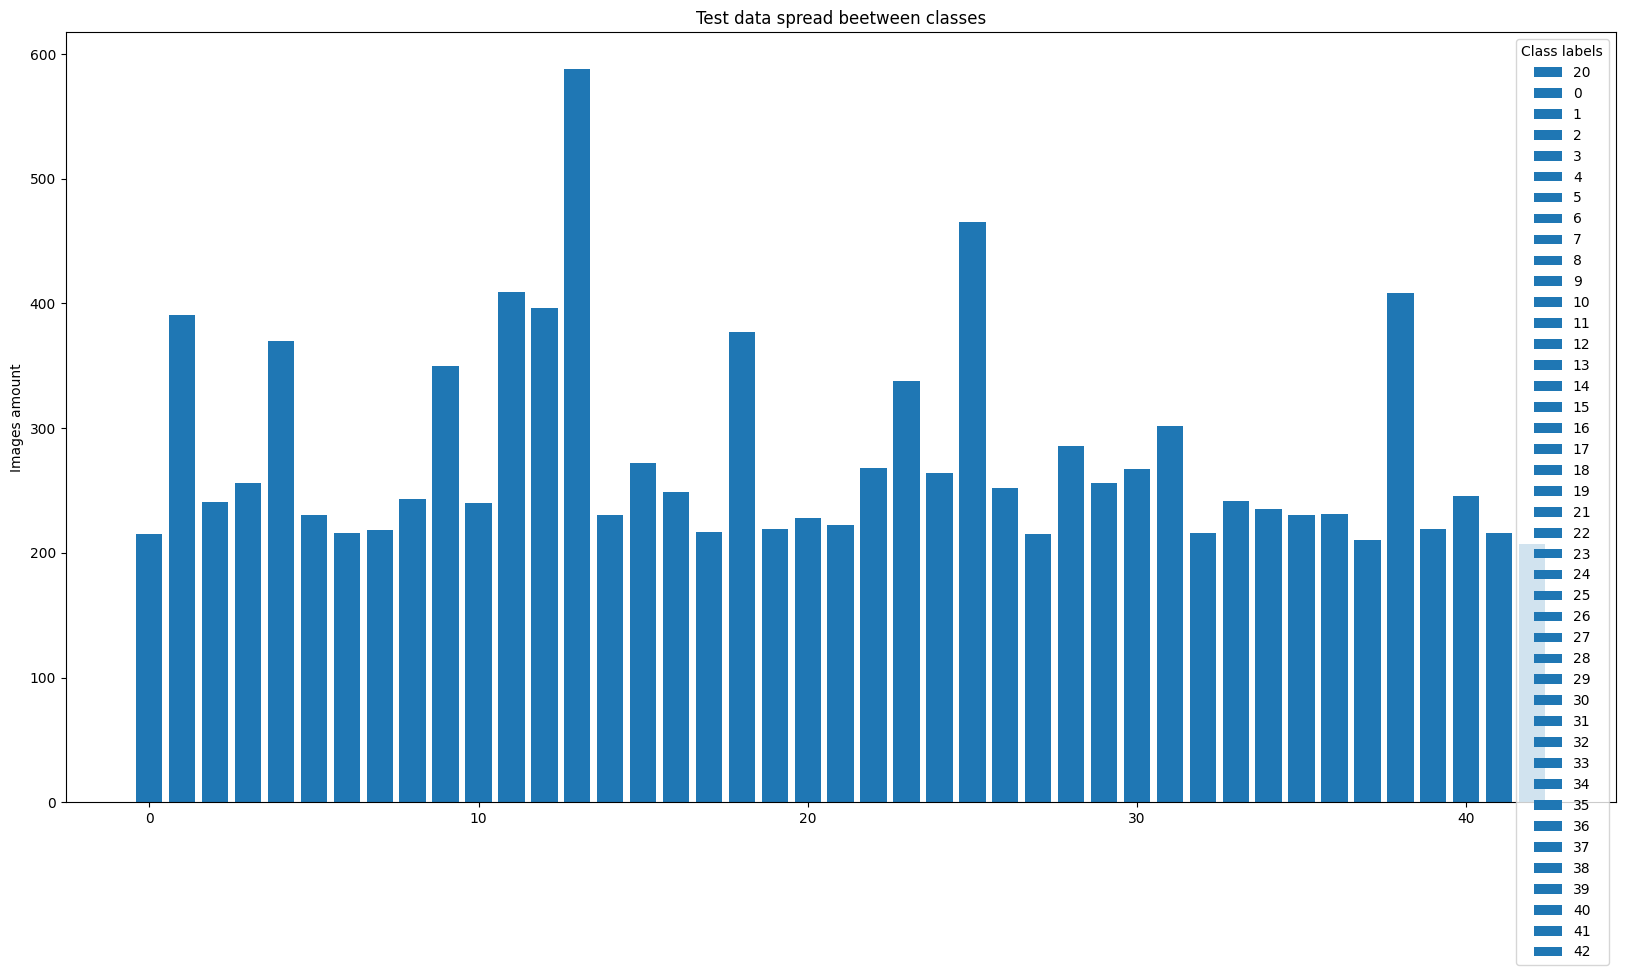

In [144]:
test_data_labels_np = np.array(test_data_labels)
dictionary_labels = {class_id: len(np.where(test_data_labels_np == class_id)[0]) for class_id in labels_file["ClassId"].unique().tolist()}
fig, ax = plt.subplots(figsize=(20,10))

labels = dictionary_labels.keys()
counts = dictionary_labels.values()
bar_labels = dictionary_labels.keys()

ax.bar(labels, counts, label=bar_labels )

ax.set_ylabel('Images amount')
ax.set_title('Test data spread beetween classes')
ax.legend(title='Class labels')
plt.savefig(fr"{dir_path}\docs\data_plot.png", dpi=300, bbox_inches="tight")
plt.show()


In [159]:
# create data for training 

X = np.array(test_data_images)
Y = np.array(test_data_labels)

# will keep test data as a path to picture to save memory space
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

print(X_train.shape)
print(y_train.shape)


(9560, 128, 128, 3)
(9560, 1)


In [160]:
# 3. chosing data model and setup
# typical architecture: Conv → Conv → Pool → Conv → Pool → Conv → Pool → Flatten → Dense

# 3. chosing data model and setup
#     3.1 Batch_size to choose                  Done
#     3.2 Adam parameters                       Done
#     3.3 Dropout                               Done
#     4.1 between education accuracy result     Done

def build_cnn(input_shape=(128, 128, 3)):  # розмір зображення 128х128, 3 канали (RGB)
    model = models.Sequential([
        layers.Conv2D(32, (4, 4), activation='relu', padding='same', input_shape=input_shape),

        # 1 згортковий блок
        layers.Conv2D(64, (4, 4), activation='relu', padding='same'), # Padding = “доповнення” зображення нулями
        layers.MaxPooling2D((2, 2)),

        # 2 згортковий блок
        layers.Conv2D(128, (4, 4), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),
        
        layers.Flatten(),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(len(dictionary_labels.keys()), activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #loss='sparse_categorical_crossentropy',  # це спеціальна версія, яка приймає цілі числа як мітки, а не one-hot.
    #loss='binary_crossentropy',
    return model



model = build_cnn()
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 128, 128, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 128, 128, 64)        │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │       8,388,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 43)                  │           2,795 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,557,067 (32.64 MB)

 Trainable params: 8,557,067 (32.64 MB)

 Non-trainable params: 0 (0.00 B)

In [161]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(fr"{dir_path}\\best_model.keras", monitor='val_loss', save_best_only=True)
]

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=16,
                    callbacks=[callbacks])

Epoch 1/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 307s 640ms/step - accuracy: 0.4151 - loss: 2.1110 - val_accuracy: 0.8468 - val_loss: 0.5646
Epoch 2/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 296s 620ms/step - accuracy: 0.7635 - loss: 0.6807 - val_accuracy: 0.9142 - val_loss: 0.2210
Epoch 3/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 293s 613ms/step - accuracy: 0.8245 - loss: 0.3932 - val_accuracy: 0.9012 - val_loss: 0.1588
Epoch 4/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 293s 613ms/step - accuracy: 0.8222 - loss: 0.3158 - val_accuracy: 0.9053 - val_loss: 0.1629
Epoch 5/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 292s 612ms/step - accuracy: 0.8163 - loss: 0.2614 - val_accuracy: 0.9069 - val_loss: 0.1288
Epoch 6/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 293s 613ms/step - accuracy: 0.8211 - loss: 0.2220 - val_accuracy: 0.8572 - val_loss: 0.1501
Epoch 7/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 293s 614ms/step - accuracy: 0.8073 - loss: 0.2024 - val_accuracy: 0.9048 - val_loss: 0.0902
Epoch 8/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 291s 610ms/step - accuracy: 

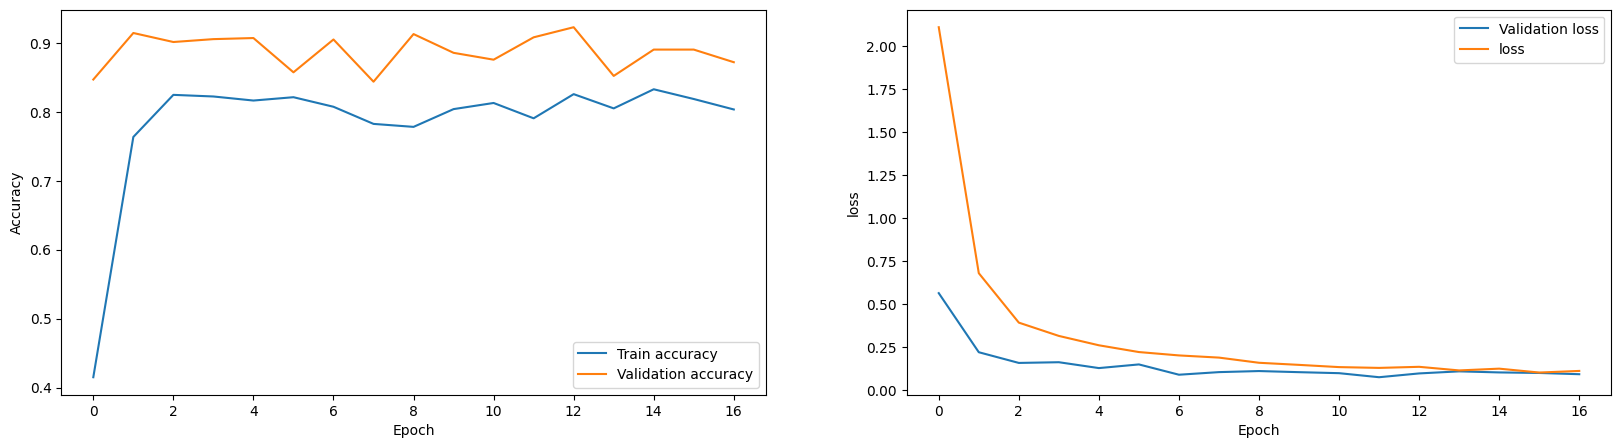

In [162]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))

axes[0].plot(history.history['accuracy'], label='Train accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation accuracy')

axes[0].legend()
#axes[0].title("Accuracy training")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")


axes[1].plot(history.history['val_loss'], label='Validation loss')
axes[1].plot(history.history['loss'], label='loss')
axes[1].legend()
#axes[1].title("loss training")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("loss")

plt.savefig(fr"{dir_path}\docs\loss_curve.png", dpi=300, bbox_inches="tight")
plt.show()

In [163]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"📊 Test accuracy: {test_accuracy:.4f}")
print(f"📉 Test loss: {test_loss:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - accuracy: 0.9213 - loss: 0.0620
📊 Test accuracy: 0.9213
📉 Test loss: 0.0620


In [166]:
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

# confusion matrix plot
cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig(fr"{dir_path}\docs\confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred_labels))
print("Classification report:\n", classification_report(y_test, y_pred_labels))

75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 252ms/step


ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets